In [1]:
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit, lax

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy.integrate as si
import scipy.optimize as so
import scipy.linalg as sl

import time

from tqdm import trange
import os 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

In [7]:
P = np.load('../logfiles/casscf22_s2_h2_sto-3g_tensor.npy')
dimat = np.load('../logfiles/casscf22_s2_h2_sto-3g_CI_dimat.npz')

trajectory_number = 135
mol = 'heh+'
method = 'tdcasscf'
prefix = '../dt0.008268/'
trajnum = trajectory_number
traj = str(trajnum).zfill(3)
fname = prefix + 'time_coeffs.' + method + '_' + mol + '_sto-3g_' + traj + '_dt=0.008268au.txt'
tdcicoeffs = np.loadtxt(fname,dtype=np.complex128)

In [8]:
ham = np.load('../logfiles/casscf22_s2_h2_sto-3g_hamiltonian.npy')
ham = ham - np.diag([np.min(ham)]*ham.shape[0])

In [9]:
runfile = np.load(prefix+'tdcasscf_heh+_sto-3g_'+str(trajnum).zfill(3)+'_dt=0.008268au.npz')
mydt = 0.008268#runfile['dt_au'].item()
print(mydt)

0.008268


In [10]:
runfile['freq']

array(0.9)

In [11]:
freq = 1.5

In [12]:
offset = 0
tvec = np.arange(offset,offset+tdcicoeffs.shape[0])*mydt
tmeoff = runfile['ncyc']*2*np.pi/freq
ef = (tvec>=0)*(tvec<=tmeoff)*(runfile['emax'])*np.sin(freq*tvec)

In [13]:
shape = 4    # this is for STO-3G
#shape = 16  # this is for 6-31G
hamCI = np.expand_dims(ham,0) - np.einsum('i,jk->ijk',ef,dimat)
hamCI = (1+0j)*hamCI
numhamCI = hamCI.shape[0]
alldd = np.zeros((numhamCI,shape),dtype=np.float64)
allvv = np.zeros((numhamCI,shape,shape),dtype=np.complex128)
allprop = np.zeros((numhamCI,shape,shape),dtype=np.complex128)
for i in range(numhamCI):
    dd, vv = np.linalg.eigh(hamCI[i,:,:])
    alldd[i,:] = dd
    allvv[i,:,:] = vv
    allprop[i,:,:] = vv @ np.diag(np.exp(-1j*mydt*alldd[i,:])) @ vv.conj().T
    

In [14]:
newtdcicoeffs = np.zeros((tdcicoeffs.shape[0],shape),dtype=np.complex128)
newtdcicoeffs[0,0] = 1.0 
for i in range(newtdcicoeffs.shape[0]-1):
    newtdcicoeffs[i+1,:] = sl.expm(-1j*(ham-ef[i]*dimat)*mydt) @ newtdcicoeffs[i,:]

bigtens = P
S = np.array([[1.0,0.659873],[0.659873,1.0]])
S == S.T

newrdmAO_p = np.einsum('ni,nj,ijab->nab',newtdcicoeffs,np.conjugate(newtdcicoeffs),bigtens)
traces_p = np.einsum('ijj->i', newrdmAO_p@S)
print(np.mean(np.abs(traces_p)))

1.9999843713181114


In [15]:
newrdmAO = np.einsum('ni,nj,ijab->nab',newtdcicoeffs,np.conjugate(newtdcicoeffs),bigtens)
tdciden = np.einsum('ni,nj->nij',newtdcicoeffs,np.conj(newtdcicoeffs))

In [16]:
print( np.linalg.norm(np.einsum('nij,njk->nik',tdciden,tdciden) - tdciden) )

7.260106378336359e-12


In [17]:
bigtens = bigtens.reshape((4**2,2**2)).astype(np.complex128)
matmulrdmAO = np.einsum('ij,jk->ik',np.transpose(tdciden,axes=[0,1,2]).reshape((-1,4*4)), bigtens).reshape((-1,2,2))

print( np.mean(np.abs(matmulrdmAO - newrdmAO)) )

0.0


In [18]:
ells = np.arange(70,72,2)

In [19]:
# matrix to convert an (nxn) Hermitian matrix to its vectorized form
drcCI = newtdcicoeffs.shape[1]
drc = 2
def mat2vec(n):
    # real part
    realmat = np.zeros((n**2,(n+1)*n//2),dtype=np.int16)
    for i in range(n):
        for j in range(n):
            row = i*n + j
            if i<=j:
                col = i*n + j - i*(i+1)//2
            else:
                col = j*n + i - j*(j+1)//2
            realmat[row,col]=1
    j = 0
    i = 0
    # taking care of constant trace and we had no idea all along
    while j < (realmat.shape[1] - 1):
        realmat[-1,j] = -1
        j += n - i*1
        i += 1
    #
    # imaginary part
    imagmat = np.zeros((n**2,(n-1)*n//2),dtype=np.int16)
    for i in range(n):
        for j in range(n):
            row = i*n + j
            if i<j:
                col = i*n + j - (i+1)*(i+2)//2
                imagmat[row,col]=1
            if i>j:
                col = j*n + i - (j+1)*(j+2)//2
                imagmat[row,col]=-1
    symmat = np.hstack([realmat, 1j*imagmat])
    return symmat

smat = mat2vec(drcCI)

In [20]:
def ind_to_pair_upper(n, i, j):
    if i < j:
        return i * (2 * n - i - 1) // 2 + j
    else:
        return j * (2 * n - j - 1) // 2 + i
n = drcCI 

upper_mapping = {}

#this is the diag upper representation
for i in range(n):
    for j in range(i, n):
        k = ind_to_pair_upper(n, i, j)
        upper_mapping[(i,j)] = k
        
def ind_to_pair_upper(n, i, j):
    if i < j:
        return i * (2 * n - i - 1) // 2 + j
    # else:
    #     return j * (2 * n - j - 1) // 2 + i
n = drcCI 

upper_wo_diag_mapping = {}

#this is the offdiag upper representation
k=10
for i in range(n):
    for j in range(i+1, n):
        upper_wo_diag_mapping[(i,j)] = k
        k+=1

In [21]:
good_cols = np.array([ 0, 2, 3])
zero_cols = np.array([ 1])
bad_inds = []
del_upper = 0
for key in list(upper_mapping.keys()):
    for c in zero_cols:
        if c in key:
            #print(key, ' bad')
            bad_inds.append(upper_mapping[key])
            del_upper+=1
            break
print(del_upper)

4


In [22]:
del_lower = 0
for key in list(upper_wo_diag_mapping.keys()):
    for c in zero_cols:
        if c in key:
            #print(key, ' bad')
            bad_inds.append(upper_wo_diag_mapping[key])
            del_lower+=1
            break
print(del_lower)

3


In [23]:
split = drcCI*(drcCI+1)//2-del_upper

In [24]:
good_inds = np.delete(np.arange(0,drcCI**2),bad_inds)
total_inds = good_inds.tolist()
total_inds.extend(bad_inds)
total_inds.sort()

print( all(total_inds == np.arange(0,drcCI**2)) )

True


In [25]:
magicind = drcCI*(drcCI+1)//2 - 1
good_inds_del = good_inds[good_inds!=magicind]

In [26]:
# ell = ells[0]
# print(ell)

In [27]:
bigtensJNP = jnp.array(bigtens)
bigtensTJNP = jnp.array(bigtens.T)
allpropJNP = jnp.array(allprop)
smatJNP = jnp.array(smat)

In [28]:
def firststep(rdmAO):
    j = ell
    bigmat = []
    bigmat.append( bigtensTJNP )
    allCmatT = []
    for i in range(1,ell+1):
        myexp = allpropJNP[j-i,:,:]
        if i==1:
            Cmat = myexp
        else:
            Cmat = Cmat @ myexp
        # note that transpose
        allCmatT.append(Cmat.T)
    
    newstack = jnp.stack(allCmatT)
    
    for i in range(1, ell+1):
        CmatT = newstack[i-1]
        Amat = CmatT.conj()
        bigmat.append( bigtensTJNP @ jnp.kron( CmatT, Amat ) )

    bigmat = jnp.concatenate(bigmat,axis=0)
    
    btrue = jnp.flipud(rdmAO[j-ell:(j+1),:]).reshape((-1))
    mprime = bigmat @ smatJNP

    # monitor singular values
    # _, ss, _ = jnp.linalg.svd(mprime[:,good_inds_del]) # , compute_uv=False)
    # if jnp.min(ss) < 1e-15:
    #     print("Warning: singular value < 1e-15 detected at time step " + str(j))

    # reconstruct full TDCI density
    xxapprox = jnp.real( jnp.linalg.pinv(mprime[:,good_inds_del],1e-12) @ (btrue - bigmat[:,-1]) )
    xxapprox2 = jnp.concatenate([xxapprox[:split-1],jnp.array([1.0]),-xxapprox[split-1:]])
    
    recon = (smatJNP[:,good_inds] @ xxapprox2).reshape((drcCI,drcCI))
    assert (recon == recon.conjugate().transpose()).all()

    # propagate in full TDCI density space via one step of MMUT!
    reconprop = allpropJNP[j,:,:] @ recon @ allpropJNP[j,:,:].conj().T

    # compute new rdm
    nextrdmAO = (reconprop.reshape((-1)) @ bigtensJNP).conj()
    return nextrdmAO, newstack

In [29]:
def loopbody(j, intup):
    rdmAO, oldstack, sv, residuals = intup
    #cond_num = []
    bigmat = []
    bigmat.append( bigtensTJNP )
    
    # note that the "icb" and "ida" here means that we are storing Cmat.T
    allpropJNPds = lax.dynamic_slice(allpropJNP,[j-1-ell,0,0],[ell,drcCI,drcCI])
    newstack = jnp.einsum('ab,icb,idc->ida',
                         allpropJNP[j-1,:,:],
                         oldstack,
                         jnp.flipud(allpropJNPds).conj(),optimize=True)

    for i in range(1, ell+1):
        CmatT = newstack[i-1]
        Amat = CmatT.conj()
        bigmat.append( bigtensTJNP @ jnp.kron( CmatT, Amat ) )

    bigmat = jnp.concatenate(bigmat,axis=0)
    rdmAOds = lax.dynamic_slice(rdmAO,[j-ell,0],[ell+1,drc**2])
    btrue = jnp.flipud(rdmAOds).reshape((-1))
    mprime = bigmat @ smatJNP
    
    # error handling inside JIT'd functions is not obvious so i'm commenting this out
    #monitor singular values
    _, ss, _ = jnp.linalg.svd(mprime[:,good_inds_del]) # , compute_uv=False)
    #cond_num.append()
    # if jnp.min(ss) < 1e-15:
    #     print("Warning: singular value < 1e-15 detected at time step " + str(j))

    # reconstruct full TDCI density
    xxapprox = jnp.real( jnp.linalg.pinv(mprime[:,good_inds_del],1e-12) @ (btrue - bigmat[:,-1]) )
   
    xxapprox2 = jnp.concatenate([xxapprox[:split-1],jnp.array([1.0]),-xxapprox[split-1:]])
    
    recon = (smatJNP[:,good_inds] @ xxapprox2).reshape((drcCI,drcCI))
    
    # error handling inside JIT'd functions is not obvious so i'm commenting this out
    # assert (recon == recon.conjugate().transpose()).all()

    # propagate in full TDCI density space via one step of MMUT!
    reconprop = allpropJNP[j,:,:] @ recon @ allpropJNP[j,:,:].conj().T

    # compute new rdm
    rdmAO = rdmAO.at[j+1].set( (reconprop.reshape((-1)) @ bigtensJNP).conj() )
    sv = sv.at[j].set(jnp.max(ss)/jnp.min(ss))
    residuals = residuals.at[j].set(jnp.linalg.norm(mprime[:,good_inds_del] @ xxapprox - (btrue - bigmat[:,-1])))
    #sv.append(jnp.max(ss)/jnp.min(ss))
    return (rdmAO, newstack, sv, residuals)

In [30]:
rdmAOs = []
cond_nums = []
MSEs = []
residuals = []

In [31]:
for ell in ells:
    start = time.time()
    
    numsteps = matmulrdmAO.shape[0]

    myrdmAOinitblock = jnp.transpose(newrdmAO[:ell+1,:,:],(0,2,1)).reshape((-1,drc**2))
    firstnewrdmAO, newstack = firststep(myrdmAOinitblock)

    myrdmAO = jnp.concatenate([myrdmAOinitblock, jnp.expand_dims(firstnewrdmAO,0), 
                               jnp.zeros((numsteps-(ell+2), drc**2), dtype=np.complex128)])
    sv = jnp.zeros((numsteps-1-ell-1))
    residual = jnp.zeros((numsteps-1-ell-1))
    outtup = lax.fori_loop(ell+1,numsteps-1,loopbody,(myrdmAO,newstack,sv,residual))
    myrdmAO = outtup[0]
    MSE = jnp.mean(jnp.square(myrdmAO[ell+1:].reshape((-1,drc,drc)).conj() - newrdmAO[ell+1:]))
    MSEs.append(MSE)
    cond_num = outtup[2]
    myresidual = outtup[3]
    end = time.time()
    print(end-start)
    rdmAOs.append(myrdmAO)
    cond_nums.append(cond_num)
    residuals.append(myresidual[-1])
    print(MSEs[-1])
    print(residuals[-1])

52.50956869125366
(1.9418390286616864e-06-9.0440440016349e-23j)
1.5533575621754363e-07


In [32]:
print(jnp.mean(jnp.square(myrdmAO[ell+1:].reshape((-1,drc,drc)).conj() - newrdmAO[ell+1:])))

(1.9418390286616864e-06-9.0440440016349e-23j)


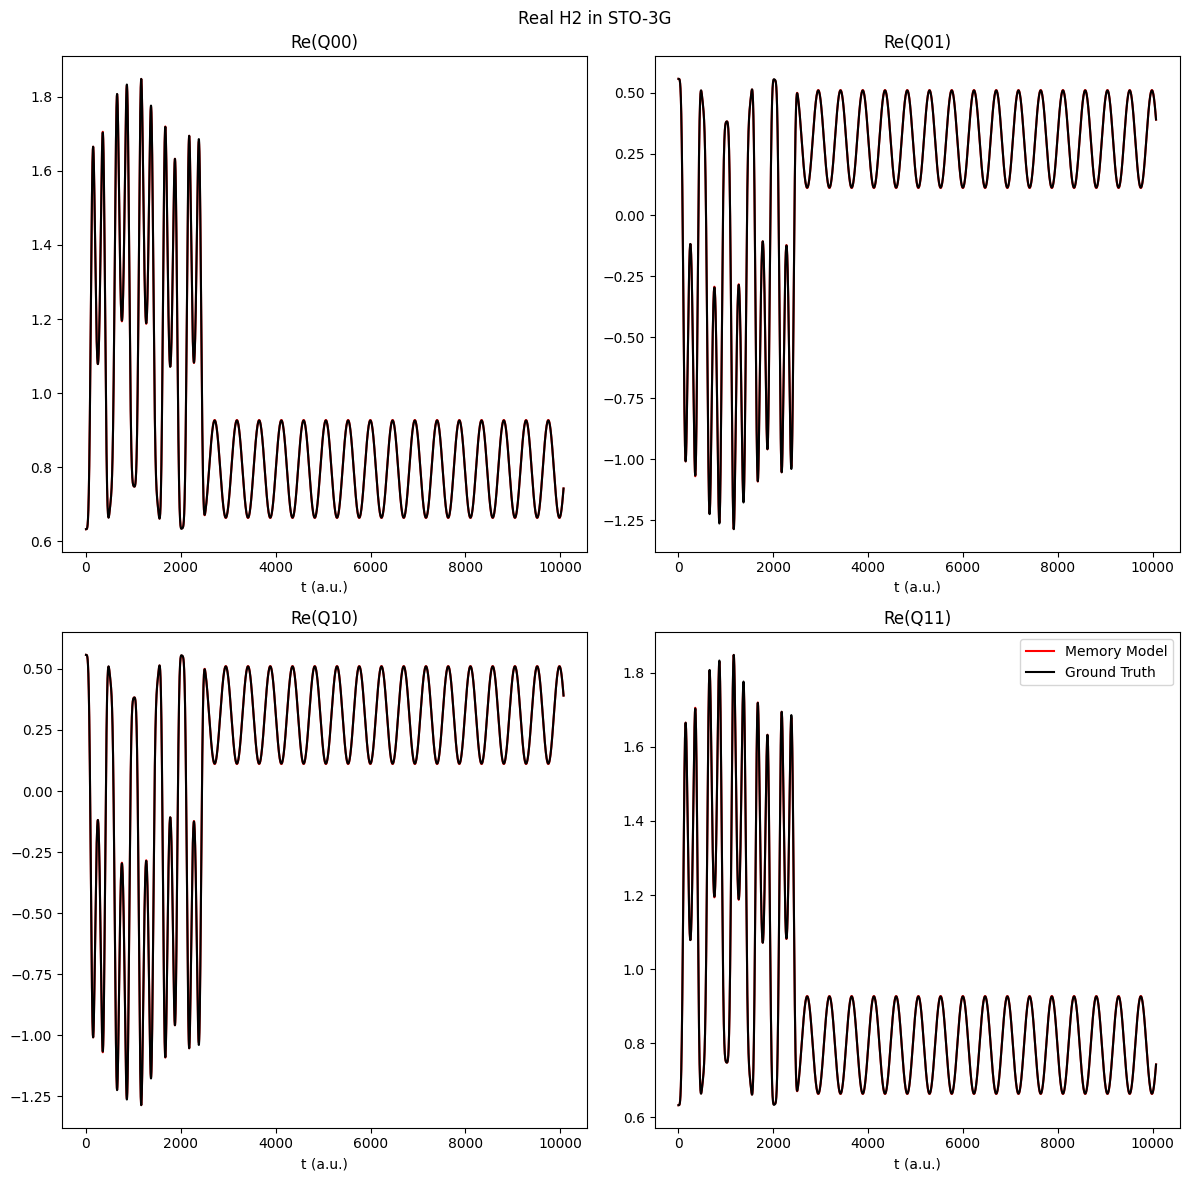

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
icnt=0
jcnt=0
for i in range(2):
    for j in range(2):
        axs[i,j].plot(np.real(myrdmAO[:ell+10000,:].reshape((ell+10000,2,2))[:,i,j]),color='red')
        axs[i,j].plot(np.real(newrdmAO[:ell+10000,i,j]),color='black')
        axs[i,j].set_title('Re(Q'+str(i)+str(j)+')')
        axs[i,j].set_xlabel('t (a.u.)')
        jcnt+=1
    icnt+=1
plt.legend(['Memory Model','Ground Truth'])
fig.suptitle('Real H2 in STO-3G')
plt.tight_layout()
plt.savefig('./figures/h2_real_post_prop_sto-3g_dt-0.082680.pdf')


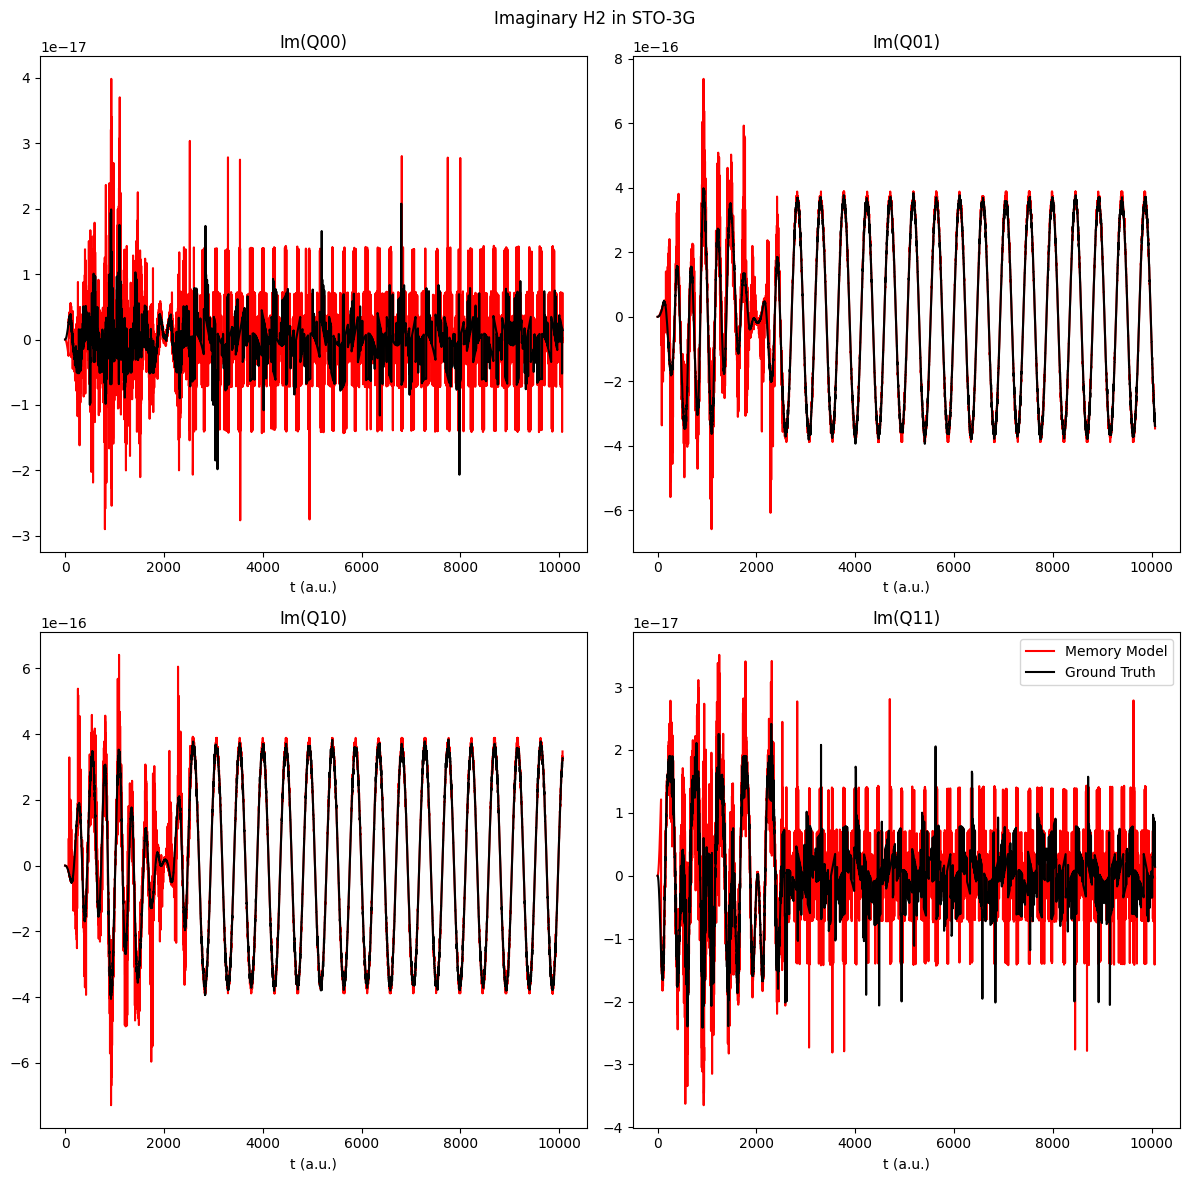

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
icnt=0
jcnt=0
for i in range(2):
    for j in range(2):
        axs[i,j].plot(np.imag(myrdmAO[:ell+10000,:].conj()).reshape((ell+10000,2,2))[:,i,j],color='red')
        axs[i,j].plot(np.imag(newrdmAO[:ell+10000,i,j]),color='black')
        axs[i,j].set_title('Im(Q'+str(i)+str(j)+')')
        axs[i,j].set_xlabel('t (a.u.)')
        jcnt+=1
    icnt+=1
plt.legend(['Memory Model','Ground Truth'])
fig.suptitle('Imaginary H2 in STO-3G')
plt.tight_layout()
#plt.savefig('imag_post_prop_6-31g.pdf')